# import

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import sys
sys.executable

'/users/samova/lcances/.miniconda3/envs/pytorch-dev/bin/python'

In [35]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time

import numpy
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.cuda.amp import autocast

from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

In [36]:
from DCT.util.dataset_loader import load_dataset
from DCT.util.optimizer_loader import load_optimizer
from DCT.util.callbacks_loader import load_callbacks
from DCT.util.model_loader import load_model
from DCT.util.preprocess_loader import load_preprocesser
from DCT.util.checkpoint import CheckPoint, mSummaryWriter
from DCT.util.utils import reset_seed, get_datetime, track_maximum

from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage

# Arguments

In [37]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../datasets", type=str)
parser.add_argument("-D", "--dataset", default="SpeechCommand", type=str, help="available [ubs8k | cifar10]")

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("-m", "--model", default="cnn03", type=str)
group_t.add_argument("--supervised_ratio", default=1.0, type=float)
group_t.add_argument("--batch_size", default=256, type=int)
group_t.add_argument("--nb_epoch", default=200, type=int)
group_t.add_argument("--learning_rate", default=0.001, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--preload_dataset", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)

group_m = parser.add_argument_group("Model parameters")
group_m.add_argument("--num_classes", default=35, type=int)

group_u = parser.add_argument_group("Datasets parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[5], type=int)

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../tensorboard/", type=str)
group_l.add_argument("--checkpoint_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args = parser.parse_args("")

tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

In [6]:
args

Namespace(batch_size=256, checkpoint_path='supervised', checkpoint_root='../model_save/', dataset='SpeechCommand', dataset_root='../datasets', from_config='', learning_rate=0.001, model='cnn03', nb_epoch=200, num_classes=35, preload_dataset=False, resume=False, seed=1234, supervised_ratio=1.0, tensorboard_path='supervised', tensorboard_root='../tensorboard/', tensorboard_sufix='', train_folds=[1, 2, 3, 4], val_folds=[5])

# initialisation

In [7]:
reset_seed(args.seed)


# Prepare the dataset

In [8]:
args.dataset_root

'../datasets'

In [9]:
train_transform, val_transform = load_preprocesser(args.dataset, "supervised")

In [11]:
manager, train_loader, val_loader = load_dataset(
    args.dataset,
    "supervised",
    
    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,

    train_transform=train_transform,
    val_transform=val_transform,
    
    num_workers=0,
    pin_memory=True,

    verbose = 2
)

../datasets/SpeechCommands/speech_commands_v0.02
Dataset already download and verified
../datasets/SpeechCommands/speech_commands_v0.02
Dataset already download and verified


In [12]:
input_shape = tuple(train_loader.dataset[0][0].shape)

# Prep model

In [13]:
torch.cuda.empty_cache()

model_func = load_model(args.dataset, args.model)
# model_func = get_model_from_name("esc_wideresnet28_8")
model = model_func(input_shape=input_shape, num_classes = args.num_classes)
model = model.cuda()


144 35


In [14]:
from torchsummary import summary

s = summary(model, input_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 64, 32]             240
         MaxPool2d-2           [-1, 24, 16, 16]               0
       BatchNorm2d-3           [-1, 24, 16, 16]              48
             ReLU6-4           [-1, 24, 16, 16]               0
            Conv2d-5           [-1, 48, 16, 16]          10,416
         MaxPool2d-6             [-1, 48, 4, 8]               0
       BatchNorm2d-7             [-1, 48, 4, 8]              96
             ReLU6-8             [-1, 48, 4, 8]               0
            Conv2d-9             [-1, 72, 4, 8]          31,176
        MaxPool2d-10             [-1, 72, 2, 4]               0
      BatchNorm2d-11             [-1, 72, 2, 4]             144
            ReLU6-12             [-1, 72, 2, 4]               0
           Conv2d-13             [-1, 72, 2, 4]          46,728
        MaxPool2d-14             [-1, 7

# training parameters

In [15]:
# tensorboard
title_element = (args.model, args.supervised_ratio, get_datetime(), model_func.__name__, args.supervised_ratio)
tensorboard_title = "%s/%sS/%s_%s_%.1fS" % title_element

title_element = (model_func.__name__, args.supervised_ratio)
checkpoint_title = "%s_%.1fS" % title_element

tensorboard = mSummaryWriter(log_dir="%s/%s" % (tensorboard_path, tensorboard_title), comment=model_func.__name__)
print(os.path.join(tensorboard_path, tensorboard_title))

# losses
loss_ce = nn.CrossEntropyLoss(reduction="mean")

../tensorboard/SpeechCommand/supervised/cnn03/1.0S/2020-09-30_13:11:52_cnn03_1.0S


In [16]:
tensorboard_params = {}
for key, value in args.__dict__.items():
    tensorboard_params[key] = str(value)

In [17]:
tensorboard.add_hparams(tensorboard_params, {})

## optimizer & callbacks

In [18]:
optimizer = load_optimizer(args.dataset, "supervised", model=model)
callbacks = load_callbacks(args.dataset, "supervised", optimizer=optimizer, nb_epoch=args.nb_epoch)


In [19]:
# Checkpoint
checkpoint = CheckPoint(model, optimizer, mode="max", name="%s/%s.torch" % (checkpoint_path, checkpoint_title))

# Metrics
fscore_fn = FScore()
acc_fn = CategoricalAccuracy()
avg = ContinueAverage()

maximum_tracker = track_maximum()

reset_metrics = lambda : [m.reset() for m in [fscore_fn, acc_fn, avg]]

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Can resume previous training

In [20]:
if args.resume:
    checkpoint.load_last()

In [21]:
args.resume

False

## training function

In [22]:
UNDERLINE_SEQ = "\033[1;4m"
RESET_SEQ = "\033[0m"


header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<8.8} {:<6.6} - {:<9.9} {:<12.12}| {:<9.9}- {:<6.6}"
value_form  = "{:<8.8} {:<6} - {:<6} - {:<8.8} {:<6.4f} - {:<9.9} {:<10.4f}| {:<9.4f}- {:<6.4f}"

header = header_form.format(
    ".               ", "Epoch", "%", "Losses:", "ce", "metrics: ", "acc", "F1 ","Time"
)


train_form = value_form
val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

print(header)

.        Epoch  - %      - Losses:  ce     - metrics:  acc         | F1       - Time  


In [23]:
def train(epoch):
    start_time = time.time()
    print("")

    reset_metrics()
    model.train()

    for i, (X, y) in enumerate(train_loader):        
        X = X.cuda()
        y = y.cuda()
        
        logits = model(X)        
        loss = loss_ce(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.set_grad_enabled(False):
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=args.num_classes)

            acc = acc_fn(pred_arg, y).mean
            fscore = fscore_fn(pred, y_one_hot).mean
            avg_ce = avg(loss.item()).mean

            # logs
            print(train_form.format(
                "Training: ",
                epoch + 1,
                int(100 * (i + 1) / len(train_loader)),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("train/Lce", avg_ce, epoch)
    tensorboard.add_scalar("train/f1", fscore, epoch)
    tensorboard.add_scalar("train/acc", acc, epoch)

In [24]:
def val(epoch):
    start_time = time.time()
    print("")
    reset_metrics()
    model.eval()

    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(val_loader):
            X = X.cuda()
            y = y.cuda()

            logits = model(X)
            loss = loss_ce(logits, y)

            # metrics
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=args.num_classes)

            acc = acc_fn(pred_arg, y).mean
            fscore = fscore_fn(pred, y_one_hot).mean
            avg_ce = avg(loss.item()).mean

            # logs
            print(val_form.format(
                "Validation: ",
                epoch + 1,
                int(100 * (i + 1) / len(val_loader)),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("val/Lce", avg_ce, epoch)
    tensorboard.add_scalar("val/f1", fscore, epoch)
    tensorboard.add_scalar("val/acc", acc, epoch)
    
    tensorboard.add_scalar("hyperparameters/learning_rate", get_lr(optimizer), epoch)
    
    tensorboard.add_scalar("max/acc", maximum_tracker("acc", acc), epoch )
    tensorboard.add_scalar("max/f1", maximum_tracker("f1", fscore), epoch )

    checkpoint.step(acc)
    for c in callbacks:
        c.step()


In [25]:
args.preload_dataset = True
if args.preload_dataset:
    train_loaded = train_loader.dataset.load_cache_from_disk("train")
    val_loaded = val_loader.dataset.load_cache_from_disk("val")
    
    if not train_loaded:
        print("No disk cache for training set")
        import tqdm

        # Training
        for i in tqdm.tqdm(range(len(train_loader.dataset))):
            _, _ = train_loader.dataset[i]
        train_loader.dataset.save_cache_to_disk("train")
        
    if not val_loaded:
        print("No disk cache for validation set")
        #val
        for i in tqdm.tqdm(range(len(val_loader.dataset))):
            _, _ = val_loader.dataset[i]
        val_loader.dataset.save_cache_to_disk("val")


In [ ]:
print(header)

start_epoch = checkpoint.epoch_counter
end_epoch = args.nb_epoch

for e in range(start_epoch, args.nb_epoch):
    train(e)
    val(e)
    
    tensorboard.flush()
tensorboard.close()

.        Epoch  - %      - Losses:  ce     - metrics:  acc         | F1       - Time  

Training 1      - 100    -          1.4696 -           0.5856    | 0.5308   - 552.8139
Validati 1      - 100    -          0.5574 -           0.8323    | 0.8407   - 47.8182


## display

AttributeError: 'SummaryWriter' object has no attribute 'history'

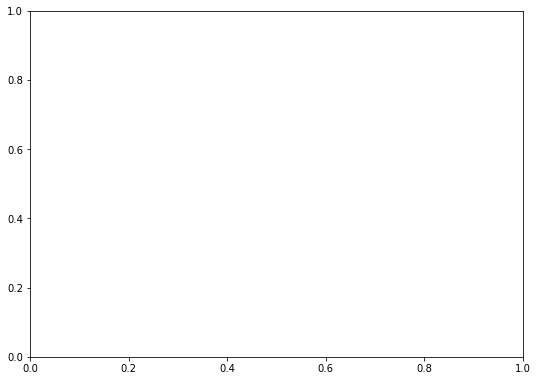

In [32]:
import matplotlib.pyplot as plt

x = list(range(checkpoint.epoch_counter))
sm = lambda y, w: np.convolve(y, np.ones(w)/w, mode='same')
pp = lambda k: plt.plot(x, tensorboard.history[k], label=f"{k} = {max(tensorboard.history[k])}")
spp = lambda k: plt.plot(x, sm(tensorboard.history[k], 5), label=f"{k} = {max(tensorboard.history[k])}")


plt.figure(0, figsize=(30, 14))
plt.subplot(2, 3, 1)
pp("val/acc")
pp("val/f1")
plt.legend()

plt.subplot(2, 3, 3)
pp("detail_hyperparameters/learning_rate")
plt.legend()

plt.show()

# Testing (only for speechcommand)

In [30]:
if args.dataset.lower() == "speechcommand":
    
    from DCT.dataset_loader.speechcommand import SpeechCommands
    from torch.utils.data import DataLoader
    from torch.nn import Sequential
    from DCT.util.transforms import PadUpTo
    from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

    transform = Sequential(
        PadUpTo(target_length=16000, mode="constant", value=0),
        MelSpectrogram(sample_rate=16000, n_fft=2048, hop_length=512, n_mels=64),
        AmplitudeToDB(),
    )

    test_dataset = SpeechCommands(root=args.dataset_root, subset="testing", download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size)

../datasets/SpeechCommands/speech_commands_v0.02
Dataset already download and verified


KeyboardInterrupt: 

In [ ]:
len(test_dataset)

In [ ]:
print(header)

start_time = time.time()
print("")
reset_metrics()
model.eval()

with torch.set_grad_enabled(False):
    for i, (X, y) in enumerate(test_loader):
        X = X.cuda()
        y = y.cuda()

        logits = model(X)
        loss = loss_ce(logits, y)

        # metrics
        pred = torch.softmax(logits, dim=1)
        pred_arg = torch.argmax(logits, dim=1)
        y_one_hot = F.one_hot(y, num_classes=args.num_classes)

        acc = acc_fn(pred_arg, y).mean
        fscore = fscore_fn(pred, y_one_hot).mean
        avg_ce = avg(loss.item()).mean

        # logs
        print(val_form.format(
            "Testing: ",
            1,
            int(100 * (i + 1) / len(val_loader)),
            "", avg_ce,
            "", acc, fscore,
            time.time() - start_time
        ), end="\r")

# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪